In [1]:
# set env LD_LIBRARY_PATH to install_path
install_path = "/Users/yumengxu/Project/Physics/cwb/cwb_source/tools/install/lib"

import os

os.environ['LD_LIBRARY_PATH'] = install_path
from pycwb import logger_init
logger_init()

# load user parameters
from pycwb.config import Config, CWBConfig
cwb_config = CWBConfig('./config.ini')
cwb_config.export_to_envs()
config = Config('./user_parameters.yaml')
config.ifo

Welcome to JupyROOT 6.26/10
2023-02-07 17:38:33,895 - pycwb.config.cwb_config - INFO - Loaded config from ./config.ini
2023-02-07 17:38:33,896 - pycwb.config.cwb_config - INFO - Environment variables loaded


['L1', 'H1', 'V1']

In [2]:
# load noise from gwf
from pycwb.modules.read_data import read_from_gwf, generate_noise
# noise = [read_from_gwf(i, config, f"frames/L1H1V1-SimStrain-9311/{ifo}-SimStrain-931158100-600.gwf", config.channelNamesRaw[i], None, None ) for i, ifo in enumerate(config.ifo)]

noise = [generate_noise(f_low=30.0, sample_rate=1024.0, duration=100, start_time = 931158400-50, seed=i)
         for i, ifo in enumerate(config.ifo)]

2023-02-07 16:38:34,414 - pycwb.modules - INFO - WDM not found, loading wavelet library


In [3]:
# generate injection from pycbc
from pycbc.waveform import get_td_waveform
hp, hc = get_td_waveform(approximant="IMRPhenomPv3",
                         mass1=20,
                         mass2=20,
                         spin1z=0.9,
                         spin2z=0.4,
                         inclination=1.23,
                         coa_phase=2.45,
                         distance=500,
                         delta_t=1.0/noise[0].sample_rate,
                         f_lower=32)
declination = 0.65
right_ascension = 4.67
polarization = 2.34
gps_end_time = 931158400
from pycwb.modules.read_data import project_to_detector
strain = project_to_detector(hp, hc, right_ascension, declination, polarization, config.ifo, gps_end_time)

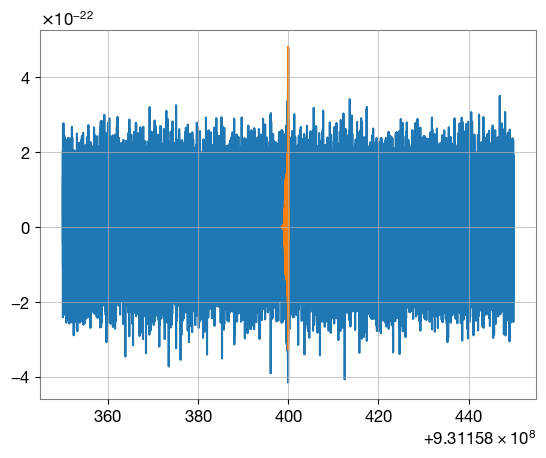

In [4]:
# inject signal into noise and convert to wavearray
injected = [noise[i].add_into(strain[i]) for i in range(len(config.ifo))]

injected[0].plot()
strain[0].plot()

Filter length = 577,  norm = 0.9999999947541458


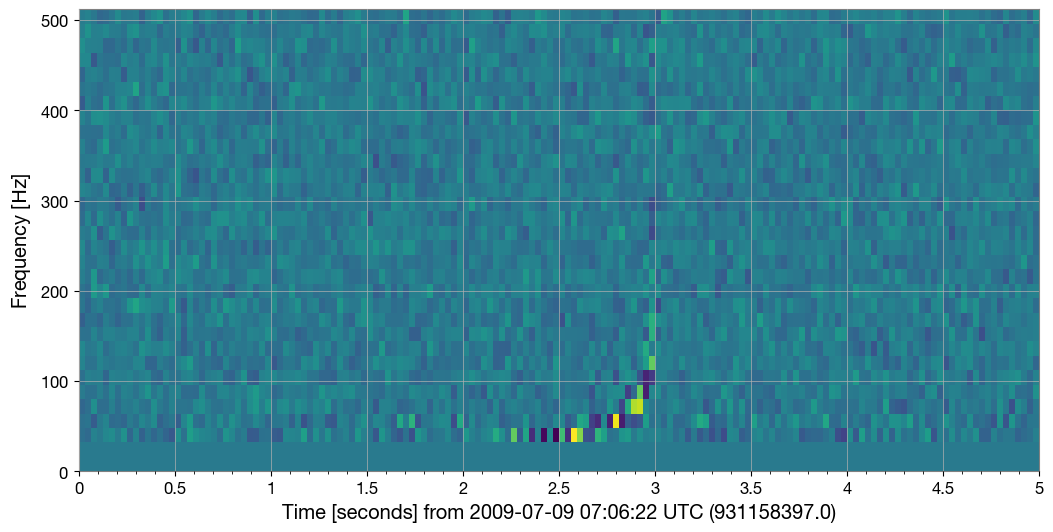

In [6]:
from pycwb.utils import convert_pycbc_timeseries_to_wavearray
wavearray = [convert_pycbc_timeseries_to_wavearray(d) for d in injected]

from pycwb.modules.plot import plot_spectrogram

plot_spectrogram(wavearray[0], xmin = gps_end_time-3, xmax = gps_end_time+2)

Filter length = 1537,  norm = 0.9999999999707183
Filter length = 1537,  norm = 0.9999999999707183
Filter length = 1537,  norm = 0.9999999999707183
Filter length = 577,  norm = 0.9999999947541458


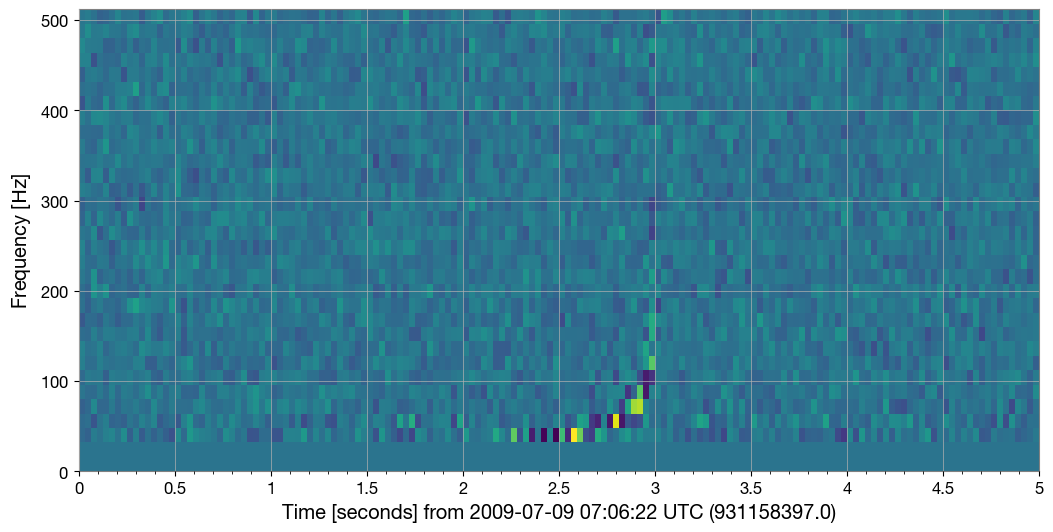

In [7]:
# data conditioning
from pycwb.modules.data_conditioning import regression, whitening
data_reg = [regression(config, wavearray[i]) for i in range(len(config.ifo))]

plot_spectrogram(data_reg[0], xmin = gps_end_time-3, xmax = gps_end_time+2)

2023-02-07 16:39:18,714 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-07 16:39:18,730 - pycwb.modules.data_conditioning.whitening - INFO - high pass filtering at 16Hz
2023-02-07 16:39:18,731 - pycwb.modules.data_conditioning.whitening - INFO - whiten  0 phase WSeries
2023-02-07 16:39:18,740 - pycwb.modules.data_conditioning.whitening - INFO - whiten 90 phase WSeries
2023-02-07 16:39:18,821 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-07 16:39:18,826 - pycwb.modules.data_conditioning.whitening - INFO - high pass filtering at 16Hz
2023-02-07 16:39:18,827 - pycwb.modules.data_conditioning.whitening - INFO - whiten  0 phase WSeries
2023-02-07 16:39:18,828 - pycwb.modules.data_conditioning.whitening - INFO - whiten 90 phase WSeries
2023-02-07 16:39:18,885 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-07 16:39:18,891 - pycwb.modules.data_conditioning.whitening - INFO - high pass filterin

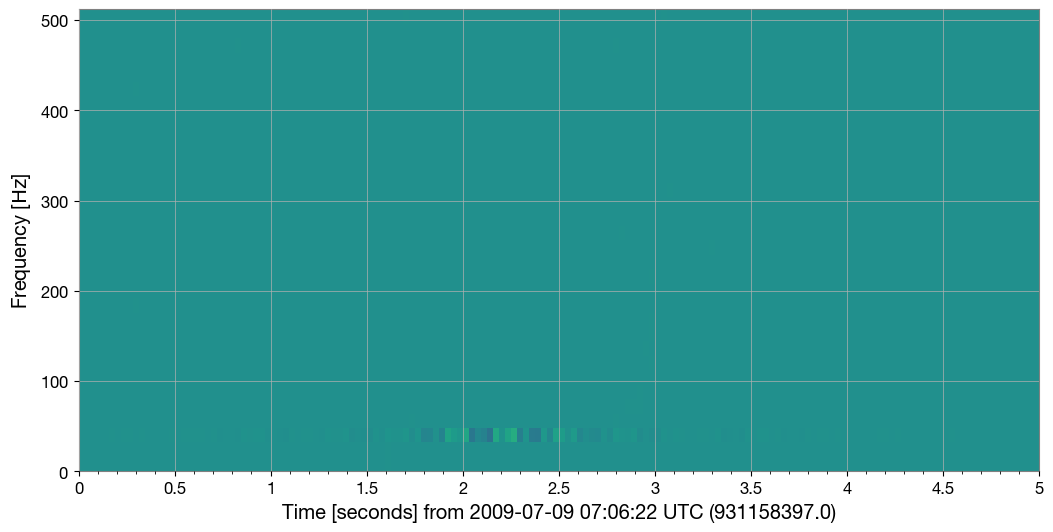

In [9]:
data_w_reg = [whitening(config, data_reg[i]) for i in range(len(config.ifo))]
tf_map = [d['TFmap'] for d in data_w_reg]

plot_spectrogram(data_w_reg[0]['TFmap'], xmin = gps_end_time-3, xmax = gps_end_time+2)


In [27]:
# initialize network
from pycwb.modules.coherence import create_network
net, wdm_list = create_network(1, config, data_w_reg)

2023-02-07 16:20:58,474 - pycwb.modules.coherence.network - INFO - Loading MRA
2023-02-07 16:20:58,540 - pycwb.modules.coherence.network - INFO - Filter length = 3.0009765625 (sec)
2023-02-07 16:20:58,672 - pycwb.modules.coherence.network - INFO - Filter length = 1.5009765625 (sec)
2023-02-07 16:20:58,722 - pycwb.modules.coherence.network - INFO - Filter length = 0.7509765625 (sec)
2023-02-07 16:20:58,771 - pycwb.modules.coherence.network - INFO - Filter length = 0.3759765625 (sec)
2023-02-07 16:20:58,820 - pycwb.modules.coherence.network - INFO - Filter length = 0.1884765625 (sec)
2023-02-07 16:20:58,872 - pycwb.modules.coherence.network - INFO - Filter length = 0.0947265625 (sec)
2023-02-07 16:20:58,873 - pycwb.modules.coherence.network - INFO - Initializing network
2023-02-07 16:20:58,873 - pycwb.modules.coherence.network - INFO - Adding ifo L1
2023-02-07 16:20:58,896 - pycwb.modules.coherence.network - INFO - Adding ifo H1
2023-02-07 16:20:58,897 - pycwb.modules.coherence.network -

In [28]:
# calculate coherence
## max energy
from pycwb.modules.coherence import max_energy
alp_list = max_energy(config, net, tf_map, wdm_list)

In [29]:
## threshold
from pycwb.modules.coherence import threshold
threshold_list = threshold(config, net, alp_list)

2023-02-07 16:21:07,839 - pycwb.modules.coherence.threshold - INFO - thresholds in units of noise variance: Eo=2356.37 Emax=4712.74
2023-02-07 16:21:07,840 - pycwb.modules.coherence.threshold - INFO - cwb2G::Coherence -RES:0-THR:2356.3690474105642
2023-02-07 16:21:07,848 - pycwb.modules.coherence.threshold - INFO - live time in zero lag: 84
2023-02-07 16:21:08,348 - pycwb.modules.coherence.threshold - INFO - thresholds in units of noise variance: Eo=2356.37 Emax=4712.74
2023-02-07 16:21:08,348 - pycwb.modules.coherence.threshold - INFO - cwb2G::Coherence -RES:1-THR:2356.3690474105642
2023-02-07 16:21:08,349 - pycwb.modules.coherence.threshold - INFO - live time in zero lag: 84
2023-02-07 16:21:08,843 - pycwb.modules.coherence.threshold - INFO - thresholds in units of noise variance: Eo=2356.37 Emax=4712.74
2023-02-07 16:21:08,843 - pycwb.modules.coherence.threshold - INFO - cwb2G::Coherence -RES:2-THR:2356.3690474105642
2023-02-07 16:21:08,844 - pycwb.modules.coherence.threshold - INFO

In [30]:
## select pixels
from pycwb.modules.coherence import select_pixels
sparse_table_list = select_pixels(config, net, tf_map, wdm_list, threshold_list)

2023-02-07 16:21:14,531 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 16:21:14,596 - pycwb.modules.coherence.select_pixels - INFO -   0|        1|    105 
2023-02-07 16:21:14,835 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 16:21:14,836 - pycwb.modules.coherence.select_pixels - INFO -   0|        1|    105 
2023-02-07 16:21:14,844 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 16:21:14,845 - pycwb.modules.coherence.select_pixels - INFO -   0|        1|    105 
2023-02-07 16:21:14,853 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 16:21:14,855 - pycwb.modules.coherence.select_pixels - INFO -   0|        1|    105 
2023-02-07 16:21:14,863 - pycwb.modules.coherence.se